### Import statements

In [58]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import os
from moviepy.editor import ImageSequenceClip
from collections import deque
import shutil
%matplotlib inline

### Load the images, separately for 'car' and 'noncar' cases

In [59]:
# Load the training/test data
car_images = glob.glob('images-with-vehicles/**/*.png')
noncar_images = glob.glob('images-without-vehicles/**/*.png')
print("Car images:", len(car_images))
print("Non-car images:", len(noncar_images))

Car images: 8792
Non-car images: 8968


### Plot the examples of the car images

We can see that the images are mostly showing cars captured from behind, or slightly from the side. This is what we need for training in this case, because we typically see other vehicles on the highway from behind/side in the project video. For general case, we need more variety of angles. 

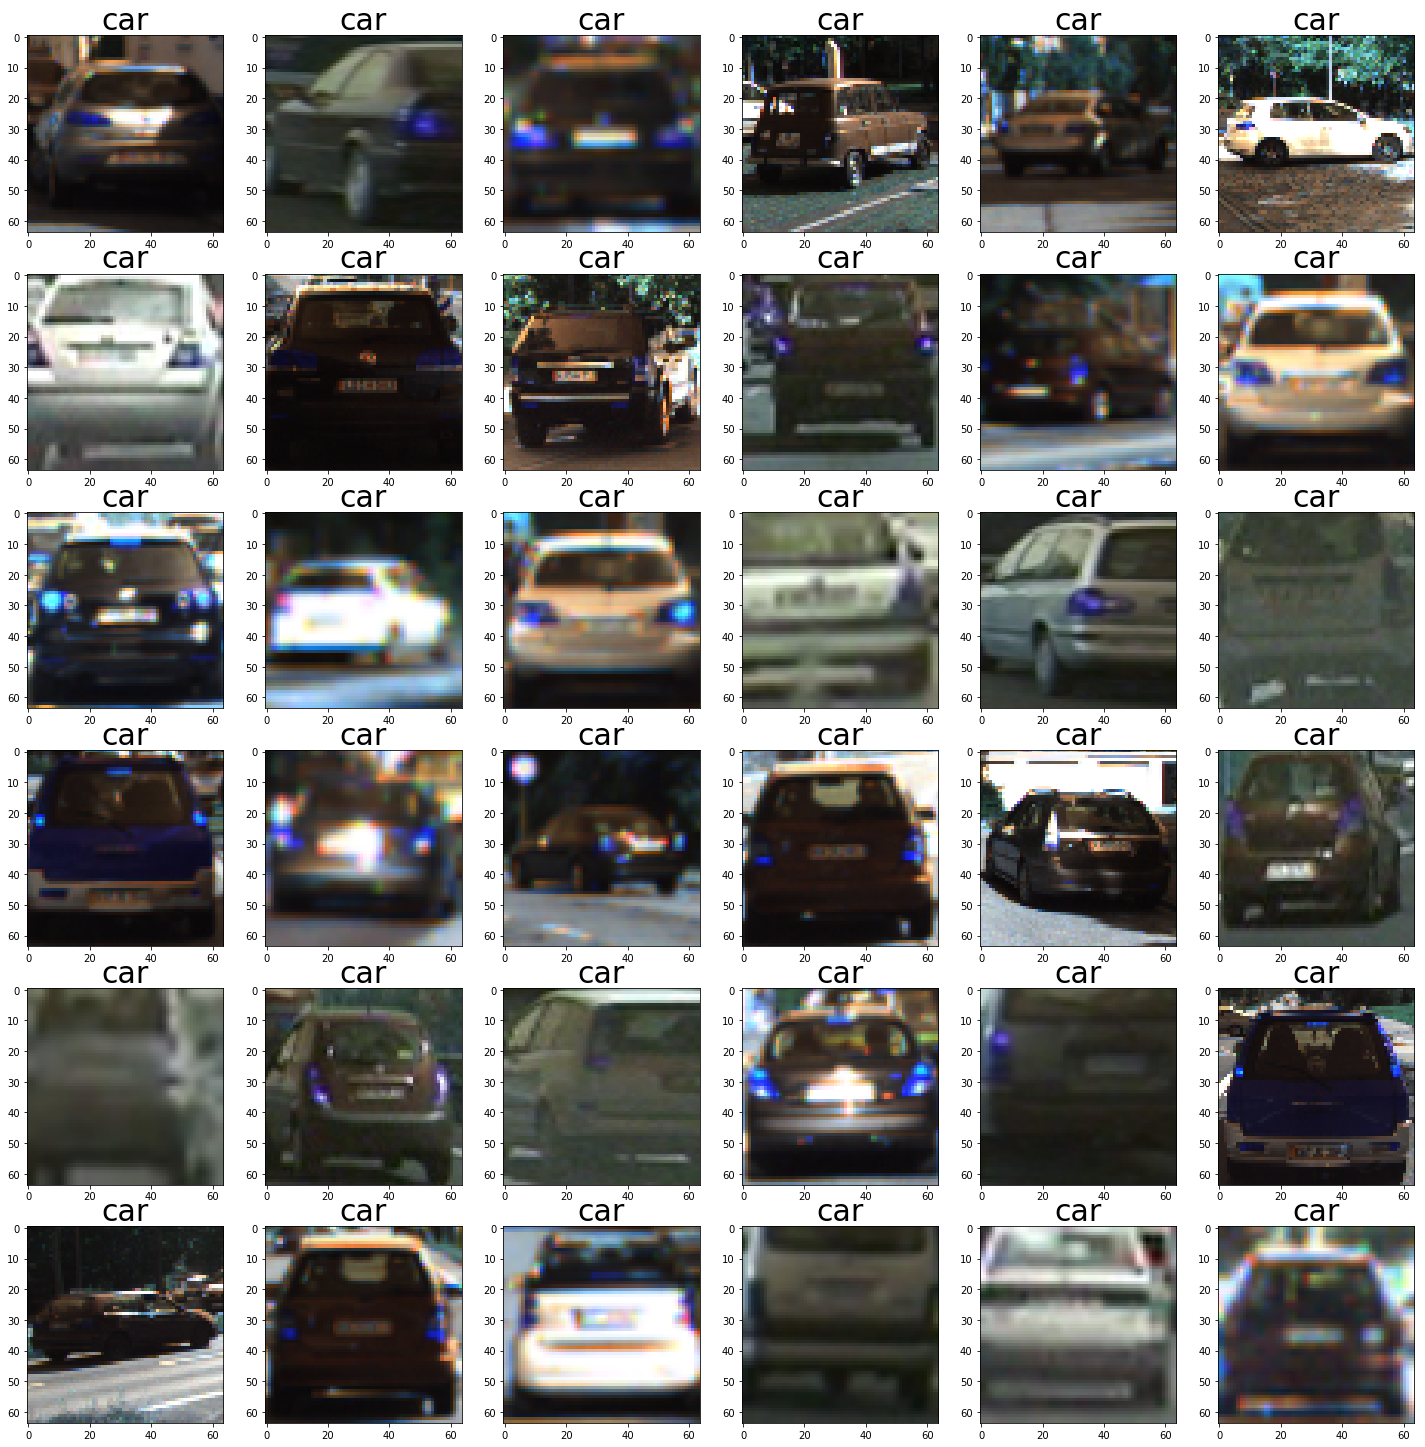

In [60]:
# Plot some examples of car images
fig, axs = plt.subplots(6,6, figsize=(20, 20))
axs = axs.ravel()
fig.tight_layout()

for i in np.arange(36):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].set_title('car', fontsize=30)
    axs[i].imshow(img)


### Plot the examples of the noncar images

If we look at the images in the noncar distribution, we see images with road side and empty roads, which is typically what we see looking forward from the car. 

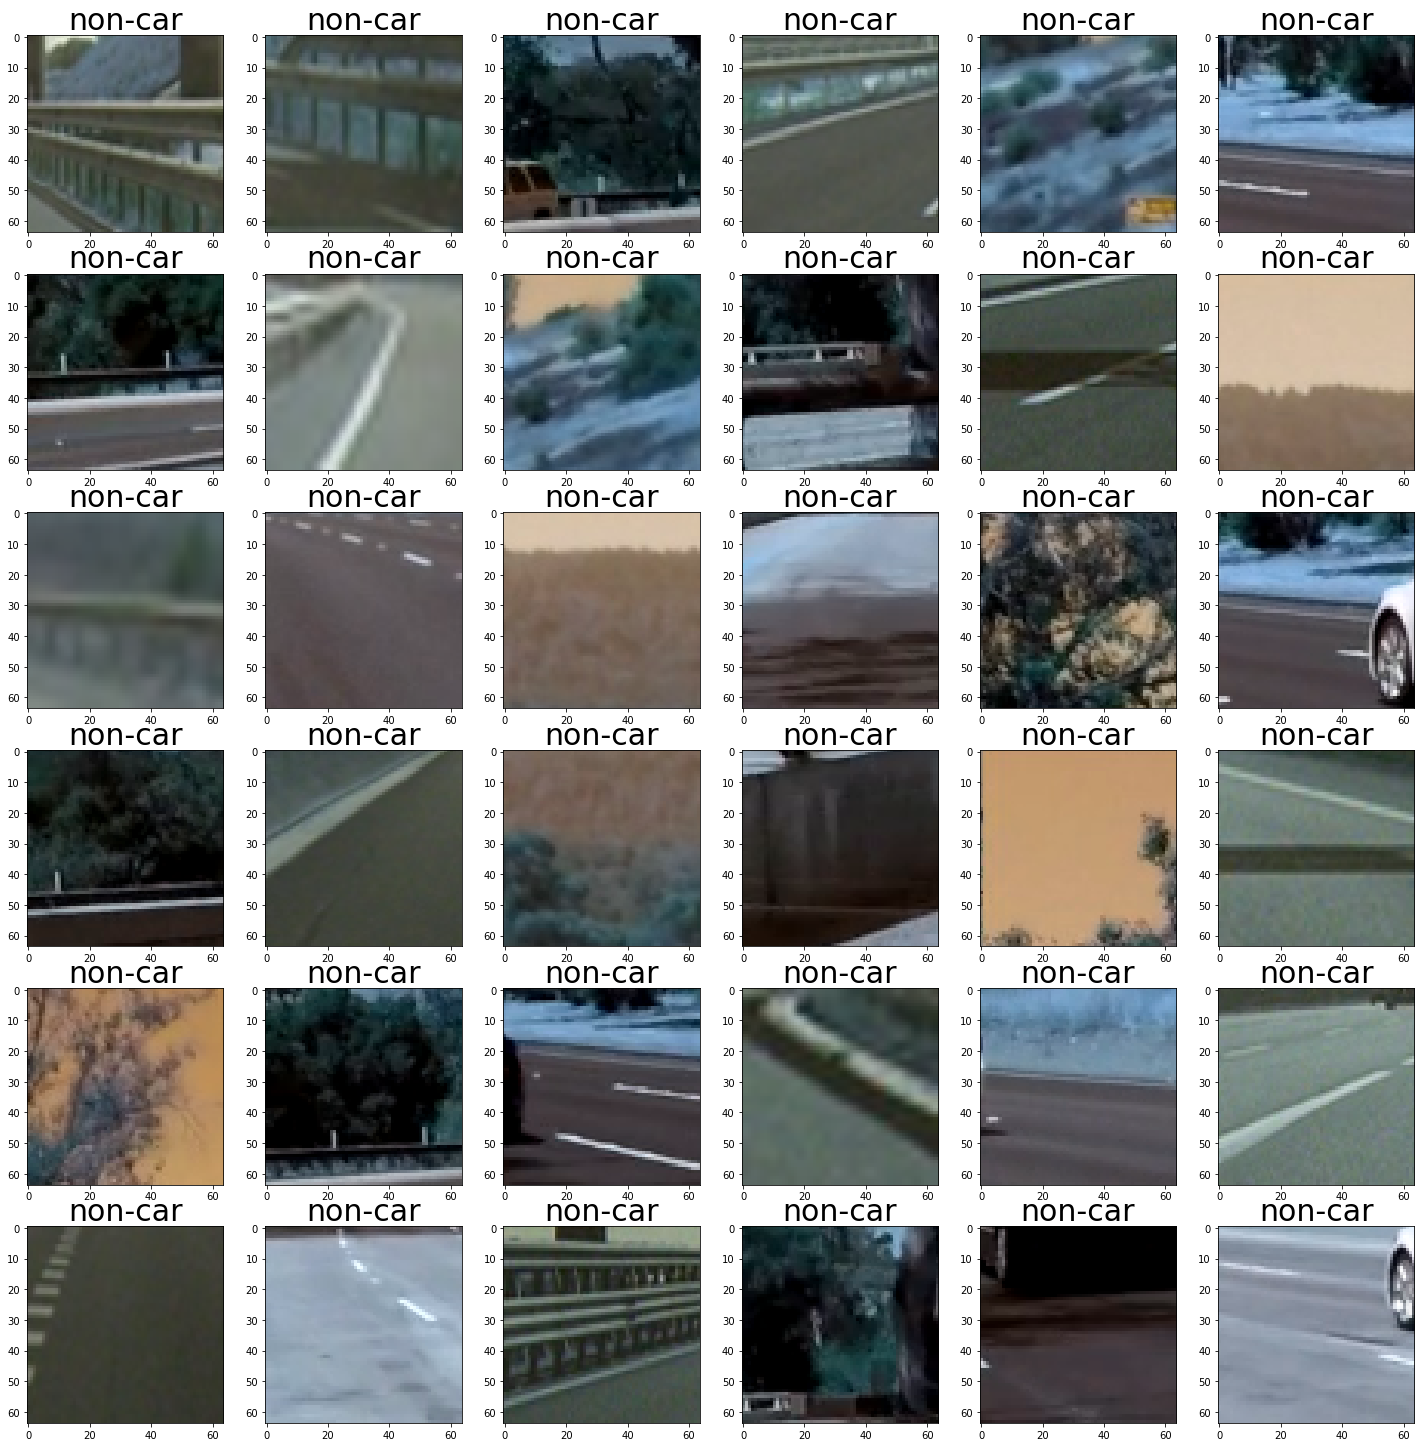

In [61]:
# Plot some examples of non-car images
fig, axs = plt.subplots(6,6, figsize=(20, 20))
axs = axs.ravel()
fig.tight_layout()

for i in np.arange(36):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    axs[i].set_title('non-car', fontsize=30)
    axs[i].imshow(img)

### Fucntions for feature extraction

We can extract three different types of features for this project:

* HOG features: histograms of oriented gradients computed separately for each channel in the image. If we have a color image(3 channels) we can decide whether to use all 3 channels or any combination of them. From the experiments performed for this project, HOG features seem to be more robust for the purpose of car detection
* Spatial features: here we attempt to recognize the car based on the template matching
* Color features: attempt to recognize the car based on the histogram of colors in the image

The importance of defining the feature vector is to get the pipeline that detects the cars robustly, but also the size of the vector should be looked at to ensure relatively fast detections (the lower the vector size, the faster the detection process). 

In [62]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    The function computes HOG features on the input image. It returns the features list, and also
    the HOG image if the flag vis is set to true
    '''

    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True, 
                              visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=True, 
                   visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    '''
    The function returns the feature vector (spatial) corresponding to the resized image
    '''
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''
    Returns the feature vector of the image corresponding to the 3 channels of the image
    The features are assembled by calculating np.histogram on each channel, and then
    by concatenating them together into a single vector
    '''
    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_image(image, color_space='RGB'):
    '''
    Read the image and convert it to the desired color format
    '''
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
    
    return feature_image
        
def extract_features_all(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Extract features from the image. The list of features is defined by the input flags
    '''
    print("Color space:", color_space)
    print("Spatial size:", spatial_size)
    print("Histogram bins:", hist_bins)
    print("HOG orientations:", orient)
    print("HOG pixels per cell:", pix_per_cell)
    print("HOG cells per block:", cell_per_block)
    print("HOG channel:", hog_channel)
    print("Use spatial features:", spatial_feat)
    print("Use histogram features:", hist_feat)
    print("Use HOG features:", hog_feat)
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # Convert image 
        feature_image = convert_image(image, color_space)

        # Call bin_spatial only if the flag is set to True
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        # Call color_hist only if the flag is set to True
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        # Compute HOG features only if the flag is set to True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Illustration of HOG 

Below we show how the HOG feature looks like for a car and a noncar image. These features can take a lot different look for different images, especially in the case of noncar images. For images of cars from behind, the HOG feature vector should be relatively robust. 

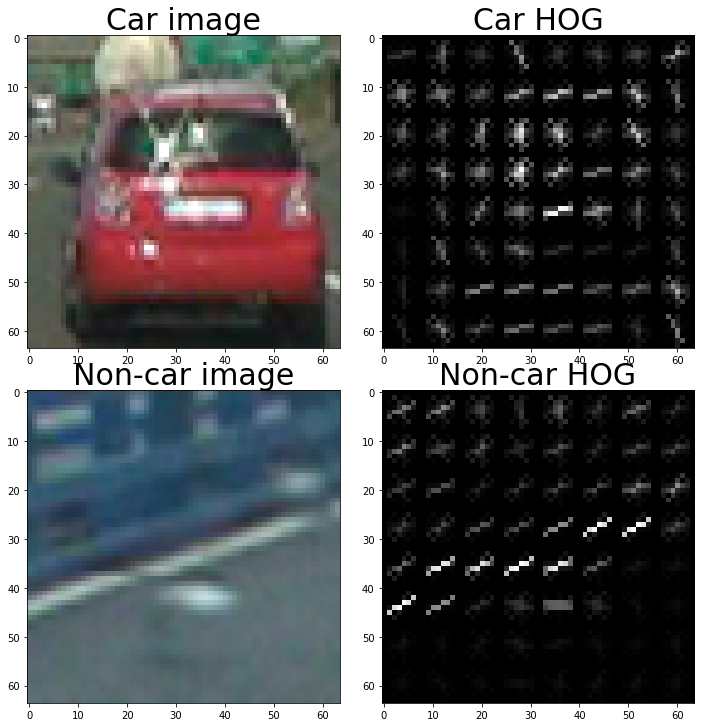

In [63]:
# Show an example of HOG for a car and a non-car image
car_img = mpimg.imread("test_images/car_image.png")
car_img_conv = convert_image(car_img, color_space="LUV")
_, car_feature_img = get_hog_features(car_img_conv[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
out_img_path = os.path.join("output_images", "car_hog.png")
mpimg.imsave(out_img_path, car_feature_img)

noncar_img = mpimg.imread("test_images/non_car_image.png")
noncar_img_conv = convert_image(noncar_img, color_space="LUV")
_, noncar_feature_img = get_hog_features(noncar_img_conv[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
out_img_path = os.path.join("output_images", "noncar_hog.png")
mpimg.imsave(out_img_path, noncar_feature_img)

# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.tight_layout()
ax1.imshow(car_img)
ax1.set_title('Car image', fontsize=30)
ax2.imshow(car_feature_img, cmap='gray')
ax2.set_title('Car HOG', fontsize=30)
ax3.imshow(noncar_img)
ax3.set_title('Non-car image', fontsize=30)
ax4.imshow(noncar_feature_img, cmap='gray')
ax4.set_title('Non-car HOG', fontsize=30)


### Configuration of the feature extraction pipeline

The cell below allows for specifying certain parameters for the rest of the notebook. We can run different experiments to pick up the best set of params for our applications. The following experiments were performed:

* Use a different combination of features. Using HOG should always be turned on because that brings the best results. For spatial and color histogram features, it was not clear that they contribute to the quality of the results. For that reason, they are turned off, which makes the size of the feature vector smaller. 
* Color space is eventually set to YCrCb. This has shown to be a good color space for HOG, and we are using all 3 channels and corresponding HOG features. 
* HOG params such as number of orientations, pixels per cell and cells per block are investigated, and the values listed below are shown to perform well. 

In [64]:
# Params for feature extraction
# Color space can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb' 
# Number of HOG orientations
orient = 11 
# Number of HOG pixels per cell
pix_per_cell = 16
# Number of HOG cells per block
cell_per_block = 2 
# HOG channel can be 0, 1, 2, or "ALL"
hog_channel = 'ALL' 
# Spatial binning dimensions
spatial_size = (16, 16) 
# Number of histogram bins
hist_bins = 32    
# Whether or not to use spatial features
spatial_feat = False 
# Whether or not to use color histogram features
hist_feat = False 
# Whether or not to use HOG features
hog_feat = True 

### Feature extraction

Here we extract features for SVM training. We separately extract car and noncar features, and generate appropriate labels, i.e. 0 and 1 for noncar and car images, respectively. Then we put the car and noncar vectors together and split them into training and test datasets. The feature data is scaled - this is probably not required if we use only the HOG feature data, but it is kept in for consistency. The scaler is fit using only the training data, and then used to scale both the training and test data separately. At this point, we are ready to train and test the classifier. 

In [65]:
# Train
print_separator = "-----"
print(print_separator)
print("Extracting features from car samples")
print(print_separator)

# Train the classifier
t_start = time.time()

car_features = extract_features_all(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t_end = time.time()
print(round(t_end - t_start, 2), 'seconds to extract car features')

print(print_separator)
print("Extracting features from non-car samples")
print(print_separator)

t_start = time.time()

notcar_features = extract_features_all(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t_end = time.time()
print(round(t_end - t_start, 2), 'seconds to extract non-car features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)        
# The vector for the labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) 

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

X_scaler = StandardScaler().fit(X_train) 
scaled_X = X_scaler.transform(X) 

X_train = X_scaler.transform(X_train)
X_test  = X_scaler.transform(X_test)

print(print_separator)

# For sanity, print out the size of the feature vector
print("Feature vector size:", len(X_train[0]))

-----
Extracting features from car samples
-----
Color space: YCrCb
Spatial size: (16, 16)
Histogram bins: 32
HOG orientations: 11
HOG pixels per cell: 16
HOG cells per block: 2
HOG channel: ALL
Use spatial features: False
Use histogram features: False
Use HOG features: True
130.6 seconds to extract car features
-----
Extracting features from non-car samples
-----
Color space: YCrCb
Spatial size: (16, 16)
Histogram bins: 32
HOG orientations: 11
HOG pixels per cell: 16
HOG cells per block: 2
HOG channel: ALL
Use spatial features: False
Use histogram features: False
Use HOG features: True
137.29 seconds to extract non-car features
-----
Feature vector size: 1188


### Training the SVM classifier

In this step we train the classifier. The time taken for training and and the test accuracy are listed below. Typically for different params setting in the feature extraction step, we get about 10 seconds of training time and 96-98 percent accuracy in the testing step. 

In [66]:
# Use the linear SVM classifier
svc = LinearSVC() 

# Train the classifier
t_start = time.time()
svc.fit(X_train, y_train) 
t_end = time.time()
print(round(t_end - t_start, 2), 'seconds to train SVC')

print(print_separator)

# Compute the test accuracy of the classifier
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) 

7.77 seconds to train SVC
-----
Test Accuracy of SVC =  0.9716


### Find cars in the input image

The cell below defines the function that finds cars in the image. The function implements the sliding window search, where the image is essentially divided into multiple overlapping windows and then each window is evaluated to check whether or not it contains the car. If it does, the window is added to the final return list. Eventually, the function returns the list of all the windows where the car was detected. 
The three important input parameters of the function are _ystart, ystop and scale_:

* _ystart_ and _ystop_ define where to start and where to stop looking at the car, respectively, looking at the vertical dimension of the image. We don't specify xstart and xstop for the horizontal dimension because we search the entire image horizontally. The parameters ystart the ystop allow us to skip searching the image at roughly the top-half where we don't expect to find any cars, and also to search only in certain parts of the image for certain sizes of the cars. For examples, the lower part of the image should contain cars that are closer to us and therefore appear larger in the image, while the part of the image near the middle should contain cars in the distance, which appear smaller in the image. 
* _scale_ defines whether to scale the image patch or not, and by how much. We typically need to scale the patch under investigation because we trained the classifier with images of fixed size, and the cars can appear smaller or larger than that in the image, depending on how far they are from us. 

Note that find_cars also contains the flag _return_all_rectangles_. If set to _True_, the function returns all the rectangles that were searched, so that we can visualize them and tune the parameters of our pipeline (e.g. in which part of the image should we specify which scale, to increase the detection performance).  

In [67]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, ystart, ystop, scale, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
              orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
              spatial_feat=True, hist_feat=True, hog_feat=True, return_all_rectangles=False, verbose=False):
    
    if verbose == True:
        print("Color space:", color_space)
        print("Spatial size:", spatial_size)
        print("Histogram bins:", hist_bins)
        print("HOG orientations:", orient)
        print("HOG pixels per cell:", pix_per_cell)
        print("HOG cells per block:", cell_per_block)
        print("HOG channel:", hog_channel)
        print("Use spatial features:", spatial_feat)
        print("Use histogram features:", hist_feat)
        print("Use HOG features:", hog_feat)

    # List of rectangles where cars were detected, or list of all rectangles, 
    # depending on the 
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    # Take only the part we want to look at for cars
    sub_img = img[ystart:ystop,:,:]

    # Convert image to the given color space
    conv_img = convert_image(sub_img, color_space)
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        img_shape = conv_img.shape
        rsz_img = cv2.resize(conv_img, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
    else:
        rsz_img = conv_img
        
    if hog_feat == True:       
        # Select image channels 
        channel_0 = rsz_img[:,:,0]
        if hog_channel == 'ALL':
            channel_1 = rsz_img[:,:,1]
            channel_2 = rsz_img[:,:,2]
        # Compute HOG for each channel separately
        hog_0 = get_hog_features(channel_0, orient, pix_per_cell, cell_per_block, feature_vec=False)   
        if hog_channel == 'ALL':
            hog_1 = get_hog_features(channel_1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog_2 = get_hog_features(channel_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            
    # Define blocks and steps as above
    num_xblocks = (channel_0.shape[1] // pix_per_cell) + 1  
    num_yblocks = (channel_0.shape[0] // pix_per_cell) + 1

    nfeat_per_block = orient * cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64

    num_blocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = 2 

    num_xsteps = (num_xblocks - num_blocks_per_window) // cells_per_step
    num_ysteps = (num_yblocks - num_blocks_per_window) // cells_per_step

    '''
    print("num_xsteps, num_ysteps", num_xsteps, num_ysteps)
    
    x_0_arr, y_0_arr = [], []
    
    for xb in range(num_xsteps):
        for yb in range(num_ysteps):
    
            y_pos_0 = yb * cells_per_step * pix_per_cell * scale
            x_pos_0 = xb * cells_per_step * pix_per_cell * scale
            x_0_arr.append(x_pos_0)
            y_0_arr.append(y_pos_0)
    
    print("X positions:", set(x_0_arr))
    print("Y positions:", set(y_0_arr))
    '''
    
    for xb in range(num_xsteps):
        for yb in range(num_ysteps):
            
            file_features = []
            
            y_pos_0 = yb * cells_per_step
            x_pos_0 = xb * cells_per_step
            y_pos_1 = y_pos_0 + num_blocks_per_window
            x_pos_1 = x_pos_0 + num_blocks_per_window
            
            if spatial_feat == True or hist_feat == True:
                
                patch_img = rsz_img[y_pos_0:y_pos_1, x_pos_0:x_pos_1]

                if spatial_feat == True:
                    spatial_features = bin_spatial(patch_img, size=spatial_size)
                    file_features.append(spatial_features)

                if hist_feat == True:
                    hist_features = color_hist(patch_img, nbins=hist_bins)
                    file_features.append(hist_features)
                    
            # Now we can extract the HOG features for the block under consideration, 
            # from already pre-computed HOG features
            if hog_feat == True:
                hog_sub_0 = hog_0[y_pos_0:y_pos_1, x_pos_0:x_pos_1].ravel()

                if hog_channel == 'ALL':
                    hog_sub_1 = hog_1[y_pos_0:y_pos_1, x_pos_0:x_pos_1].ravel()
                    hog_sub_2 = hog_2[y_pos_0:y_pos_1, x_pos_0:x_pos_1].ravel()
                    hog_features = np.hstack((hog_sub_0, hog_sub_1, hog_sub_2))
                else:
                    hog_features = hog_sub_0

                # Append the HOG feature vector to the features list
                file_features.append(np.ravel(hog_features)) 

            file_features = np.concatenate(file_features)
            file_features = file_features.reshape([1, len(file_features)])
            # Scale the features to create the final feature vector for prediction
            test_features = X_scaler.transform(file_features)    

            # test_prediction = svc.predict(hog_features)
            test_prediction = svc.predict(test_features)

            # Add the rectangle
            # If return_all_rectangles is true, all rectangles are added, otherwise
            # only those with successful prediction
            if test_prediction == 1 or return_all_rectangles:

                win_scaled = np.int(window * scale)

                x_left  = np.int(x_pos_0 * pix_per_cell * scale)
                y_top   = np.int(y_pos_0 * pix_per_cell * scale) + ystart
                x_right = x_left + win_scaled
                y_bot   = y_top + win_scaled

                rect = ((x_left, y_top),(x_right,y_bot))

                rectangles.append(rect)
                
    return rectangles

### Test find_cars on one test image

Here we take a single test image and test our function. We use _ystart_, _ystop_ and _scale_ for this particular image, and print the number of rectangles with the positive detection. 

In [68]:
# test_img = mpimg.imread('./test_images/test1.jpg')
test_img = mpimg.imread('./test_images/test6.jpg')

ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, svc, X_scaler, ystart, ystop, scale, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=False, verbose=True)

print(len(rectangles), 'rectangles found in image')

Color space: YCrCb
Spatial size: (16, 16)
Histogram bins: 32
HOG orientations: 11
HOG pixels per cell: 16
HOG cells per block: 2
HOG channel: ALL
Use spatial features: False
Use histogram features: False
Use HOG features: True
3 rectangles found in image


### Draw the rectangles onto the image

Here we define the function to draw rectangles where the cars were detected. In this particular case, we see that there are also some false positives detected, which is not completely unexpected, but should be rare and not repeatable over successive frames, as will be shown in the output video. 

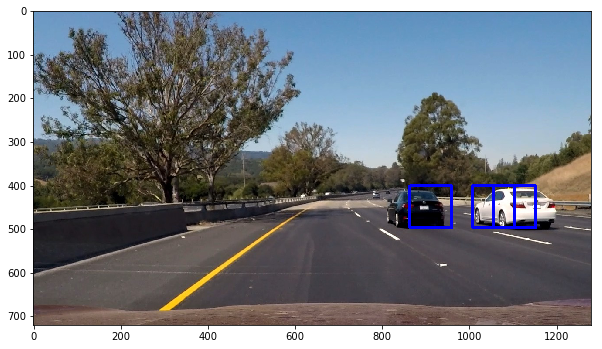

In [69]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    The function draws on the image all the rectangles specified in the bboxes input param
    '''
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img_with_rectangles = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_with_rectangles)
out_img_path = os.path.join("output_images", "test_img_with_rectangles.png")
mpimg.imsave(out_img_path, test_img_with_rectangles)

### Defining search patches

Now we need to experiment how to define search patches for the image, so that we look at the right place for the right scaling factor. We use the list called _step_config_ to define the y patches for the given scale. 

In the code below, we see that _stop_config_ contains the tuples of 4 numbers: the step between two consecutive horizontal patches, the starting coordinate of the first patch, the scale, and the number of patches. In the example in the next scale, we essentially use two patches of scale 1, the first starting at 400 and the second at 416. 

For different scales, we will define different step configs and then we put them all together into the final pipeline.

Searching at: [(400, 464, 1), (416, 480, 1)]
Number of boxes:  78


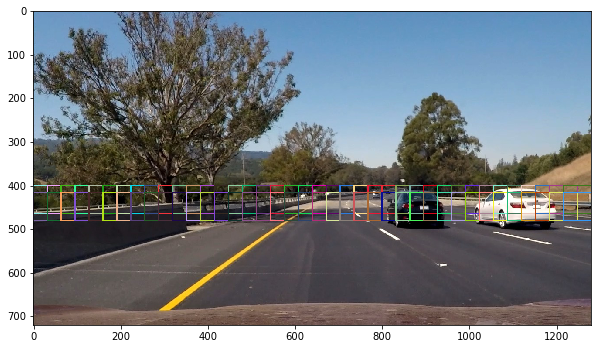

In [70]:
# Configuration for scale 1

search_items = []
step_config  = []
rectangles   = []

step_config.append((16, 400, 1, 2))

for conf in step_config:
    y_step   = conf[0]
    y_start  = conf[1]
    scale    = conf[2]
    num_step = conf[3]
    win_size = 64 * scale

    for i in range(num_step):
        y_0 = y_start + i * y_step
        y_1 = y_0 + win_size
        search_items.append((y_0, y_1, scale))

print("Searching at:", search_items)

for item in search_items:
    ystart = int(item[0])
    ystop  = int(item[1])
    scale  = item[2]
    rectangles.append(find_cars(test_img, svc, X_scaler, ystart, ystop, scale, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=True))

rectangles = [item for sublist in rectangles for item in sublist] 

test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
out_img_path = os.path.join("output_images", "windows_scale_1.png")
mpimg.imsave(out_img_path, test_img_rects)
print('Number of boxes: ', len(rectangles))

Here we repeat the process for step_config for scale 1.5 

Searching at: [(400, 496.0, 1.5), (432, 528.0, 1.5)]
Number of boxes:  50


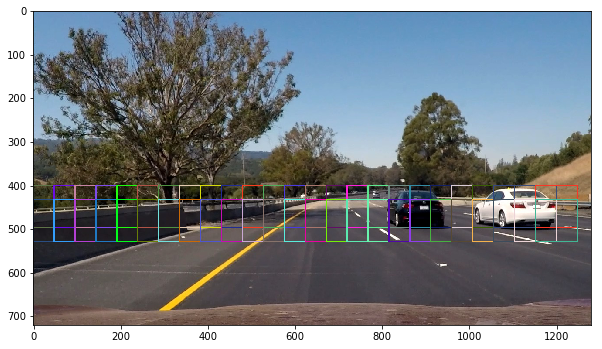

In [71]:
# Configuration for scale 1.5

search_items = []
step_config  = []
rectangles   = []

step_config.append((32, 400, 1.5, 2))

for conf in step_config:
    y_step   = conf[0]
    y_start  = conf[1]
    scale    = conf[2]
    num_step = conf[3]
    win_size = 64 * scale

    for i in range(num_step):
        y_0 = y_start + i * y_step
        y_1 = y_0 + win_size
        search_items.append((y_0, y_1, scale))

print("Searching at:", search_items)

for item in search_items:
    ystart = int(item[0])
    ystop  = int(item[1])
    scale  = item[2]
    rectangles.append(find_cars(test_img, svc, X_scaler, ystart, ystop, scale, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=True))

rectangles = [item for sublist in rectangles for item in sublist] 

test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
out_img_path = os.path.join("output_images", "windows_scale_15.png")
mpimg.imsave(out_img_path, test_img_rects)
print('Number of boxes: ', len(rectangles))

Here we repeat the process for step_config for scale 2

Searching at: [(400, 528, 2), (432, 560, 2)]
Number of boxes:  38


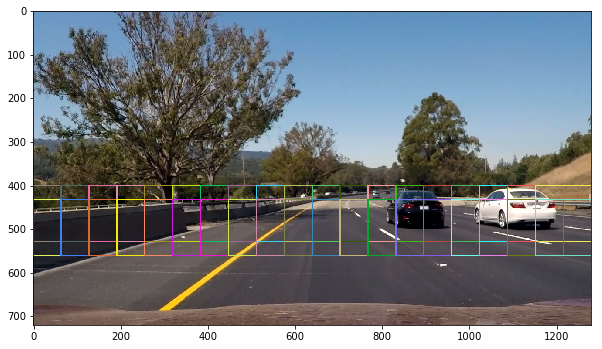

In [72]:
# Configuration for scale 2

search_items = []
step_config  = []
rectangles   = []

step_config.append((32, 400, 2, 2))

for conf in step_config:
    y_step   = conf[0]
    y_start  = conf[1]
    scale    = conf[2]
    num_step = conf[3]
    win_size = 64 * scale

    for i in range(num_step):
        y_0 = y_start + i * y_step
        y_1 = y_0 + win_size
        search_items.append((y_0, y_1, scale))

print("Searching at:", search_items)

for item in search_items:
    ystart = int(item[0])
    ystop  = int(item[1])
    scale  = item[2]
    rectangles.append(find_cars(test_img, svc, X_scaler, ystart, ystop, scale, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=True))

rectangles = [item for sublist in rectangles for item in sublist] 

test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
out_img_path = os.path.join("output_images", "windows_scale_2.png")
mpimg.imsave(out_img_path, test_img_rects)
print('Number of boxes: ', len(rectangles))

Here we repeat the process for step_config for scale 3.5 

Searching at: [(400, 624.0, 3.5), (464, 688.0, 3.5)]
Number of boxes:  20


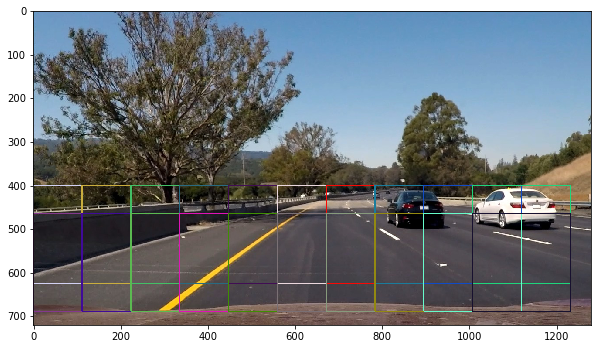

In [73]:
# Configuration for scale 3.5

search_items = []
step_config  = []
rectangles   = []

step_config.append((64, 400, 3.5, 2))

for conf in step_config:
    y_step   = conf[0]
    y_start  = conf[1]
    scale    = conf[2]
    num_step = conf[3]
    win_size = 64 * scale

    for i in range(num_step):
        y_0 = y_start + i * y_step
        y_1 = y_0 + win_size
        search_items.append((y_0, y_1, scale))

print("Searching at:", search_items)

for item in search_items:
    ystart = int(item[0])
    ystop  = int(item[1])
    scale  = item[2]
    rectangles.append(find_cars(test_img, svc, X_scaler, ystart, ystop, scale, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=True))

rectangles = [item for sublist in rectangles for item in sublist] 

test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
out_img_path = os.path.join("output_images", "windows_scale_35.png")
mpimg.imsave(out_img_path, test_img_rects)
print('Number of boxes: ', len(rectangles))

### Complete search function

In the cell below, we define the function that combines searching for different scales with different configuration steps. It returns the list of all detected windows for all scales. 

In [74]:
def search_all_windows(img, svc, X_scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
              orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
              spatial_feat=True, hist_feat=True, hog_feat=True, return_all_rectangles=False, verbose=False):
    '''
    The function returns the complete list of windows in which the cars are detected. 
    It runs at different scales, and returns the combined output for all scales
    '''
    rectangles = []
    search_items = []
    
    step_config = []
    # y_step, y_start, scale, num_steps
   
    
    step_config.append((16, 400, 1, 2))
    step_config.append((32, 400, 1.5, 2))
    step_config.append((32, 400, 2, 2))
    step_config.append((64, 400, 3.5, 2))
    
    for conf in step_config:
        y_step   = conf[0]
        y_start  = conf[1]
        scale    = conf[2]
        num_step = conf[3]
        win_size = 64 * scale

        for i in range(num_step):
            y_0 = y_start + i * y_step
            y_1 = y_0 + win_size
            search_items.append((y_0, y_1, scale))

    if verbose == True:
        print("Searching at:", search_items)
    
    for item in search_items:
        ystart = int(item[0])
        ystop  = int(item[1])
        scale  = item[2]
        rectangles.append(find_cars(img, svc, X_scaler, ystart, ystop, scale, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=False))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    return rectangles

### Test the search function on the single image

Searching at: [(400, 464, 1), (416, 480, 1), (400, 496.0, 1.5), (432, 528.0, 1.5), (400, 528, 2), (432, 560, 2), (400, 624.0, 3.5), (464, 688.0, 3.5)]


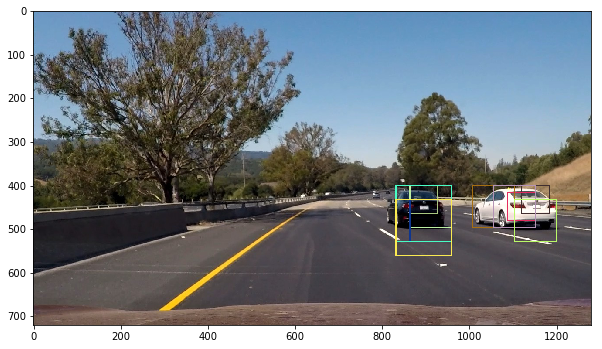

In [75]:
test_img = mpimg.imread('./test_images/test6.jpg')

rectangles = search_all_windows(test_img, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=False, verbose=True)
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
out_img_path = os.path.join("output_images", "test_img_with_pipeline_rect.png")
mpimg.imsave(out_img_path, test_img_rects)

### Heatmap

The fucntion belows create the heatmap for the detected windows. In general, the function starts with zeros across the entire image, and looks at all the pixels in the image together with the windows where the cars are detected. For each pixel, the value is increased by one for each detected window that contains that pixel. Eventually, some pixels will have 0, some will have 1 (detected within the single window), but some will have values greater than 1 if contained within multiple windows. 

The function also has the flag use_hist, so that it can create the heatmap taking into account heatmaps of several previous frames. This helps the drawn bounding boxes to be more stable, because in each frame we don't typically have the same exact detections as in the previous frames (also because the cars are moving). 

In [76]:
hist_heat = deque([])
hist_size_limit = 5

def add_heat_hist(heatmap, bbox_list, use_hist=True):
    '''
    Create the heatmap of the image, but take into account the specified number of 
    previous frames
    '''
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    if use_hist == True:
        hist_size = len(hist_heat)
        for i in range(hist_size):
            for hbox in hist_heat[i]:
                heatmap[hbox[0][1]:hbox[1][1], hbox[0][0]:hbox[1][0]] += 1
        hist_heat.append(bbox_list)
        if hist_size > hist_size_limit:
            _ = hist_heat.popleft()
    # Return updated heatmap
    return heatmap

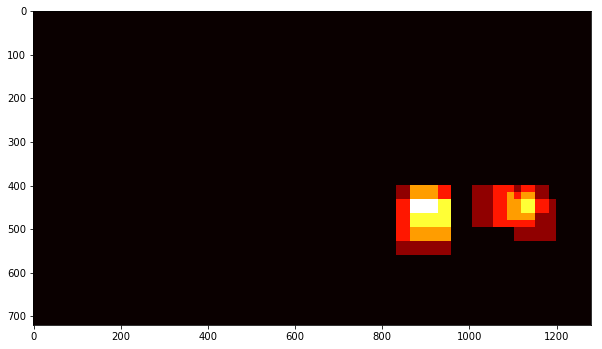

In [77]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat_hist(heatmap_img, rectangles, use_hist=False)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
out_img_path = os.path.join("output_images", "heatmap.png")
mpimg.imsave(out_img_path, heatmap_img)

### Heatmap with threshold

We can also choose to apply a certain threshold with the heatmap and only keep the values that are above the threshold. This helps especially if we use the history of heatmaps, i.e. heatmaps of several previous frames, but also to eliminate false positives. 

In [78]:
def apply_threshold(heatmap, threshold):
    '''
    The function applies the threshold and returns the modified heatmap where
    only the values above the threshold are kept
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

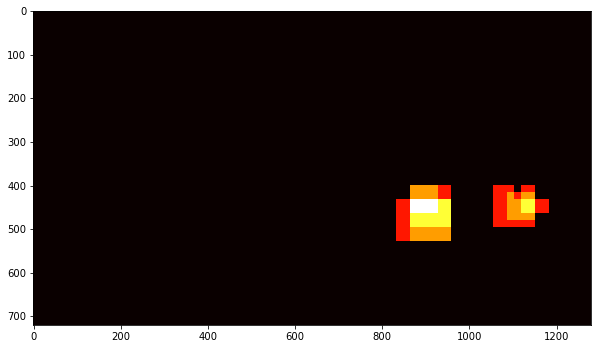

In [79]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
out_img_path = os.path.join("output_images", "heatmap_thresh.png")
mpimg.imsave(out_img_path, heatmap_img)

### Convert heatmaps to labels

Below we use the function _labels_ from SciPy to convert heatmap to individual labels. Each "blob" in the heatmap gets its own label, which we can use to eventually draw bounding boxes. 

2 cars found


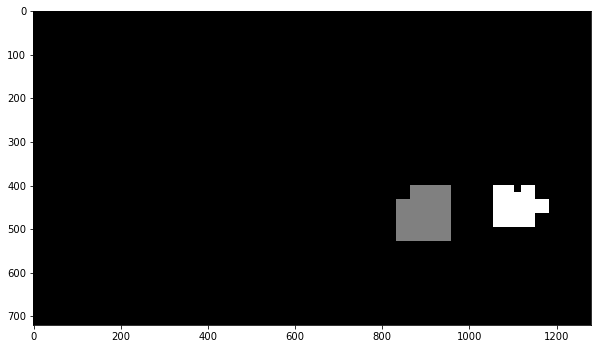

In [80]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
out_img_path = os.path.join("output_images", "labels.png")
mpimg.imsave(out_img_path, labels[0])

### Draw rectangles for labels

For each label, we can now draw a rectangle, and that is what the following function does. This helps us to smooth the edges of the labelled blobs in the figure above. 

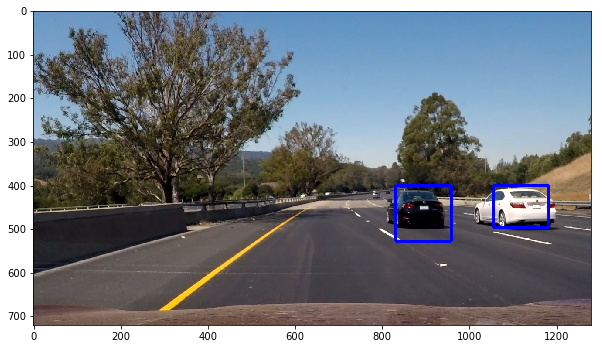

In [81]:
def draw_labeled_bboxes(img, labels):
    '''
    Draw rectangles around the labels in the given image
    '''
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if nonzerox.size == 0 or nonzeroy.size == 0:
            continue
        xmin = np.min(nonzerox)
        ymin = np.min(nonzeroy)
        xmax = np.max(nonzerox)
        ymax = np.max(nonzeroy)
        # print(xmin, ymin, xmax, ymax)
        bbox = ((xmin, ymin), (xmax, ymax))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
out_img_path = os.path.join("output_images", "test_orig_detected.png")
mpimg.imsave(out_img_path, draw_img)

### Putting everything together

We are now ready to define the function that implements our processing pipeline. We have the following steps:
    
* Step 1: Perform sliding windows search at different scales to detect the cars
* Step 2: Generate heatmap, potentially using several previous frames together with the current frame
* Step 3: Generate labels for the given heatmap
* Step 4: Draw rectangles for each label

In [82]:
def process_frame(img, svc, X_scaler, color_space='YUV', spatial_size=(32, 32), hist_bins=32, 
              orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', 
              spatial_feat=False, hist_feat=False, hog_feat=True, use_labels_hist=False, use_heat_hist=False, heat_thresh=1):

    '''
    Implement the final processing pipeline
    '''
    
    # Step 1: Perform sliding windows search at different scales to detect the cars
    rectangles = search_all_windows(img, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, return_all_rectangles=False)
    
    # Step 2: Generate heatmap, potentially using several previous frames together with the current frame
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat_hist(heatmap_img, rectangles, use_hist=use_heat_hist)
    heatmap_img = apply_threshold(heatmap_img, heat_thresh)
    
    # Step 3: Generate labels for the given heatmap
    labels = label(heatmap_img)
    
    # Step 4: Draw rectangles for each label    
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

### Testing the final processing pipeline

Below we test the final processing pipeline on the six images provided in the test_images folder. 

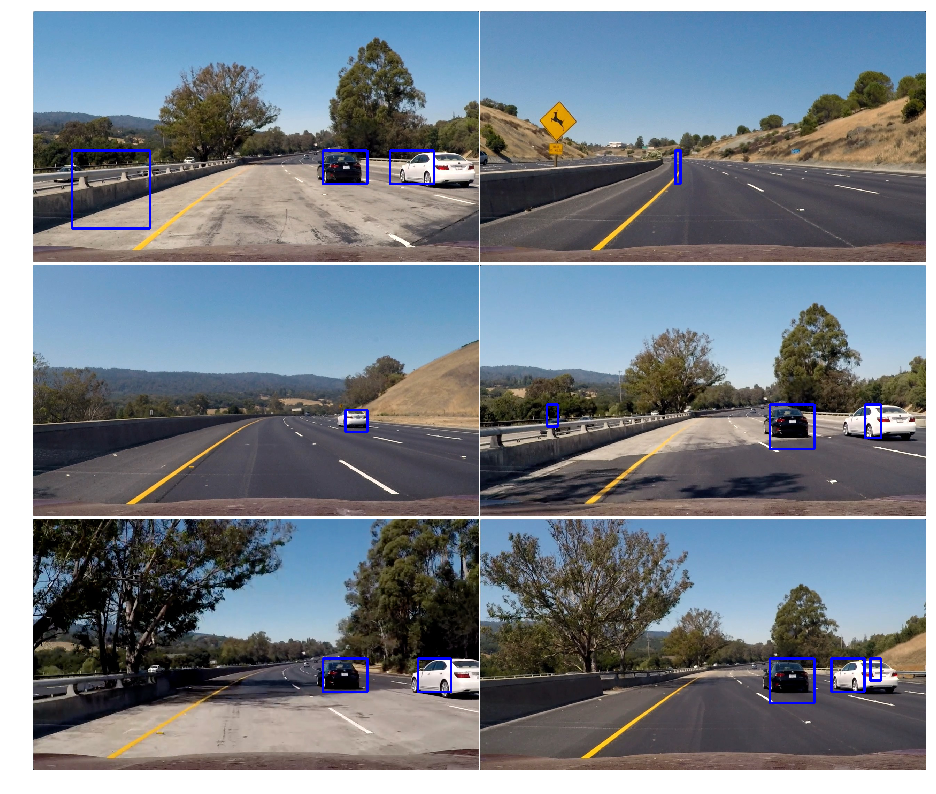

In [83]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    proc_frame = process_frame(mpimg.imread(im), svc, X_scaler)
    out_img_path = os.path.join("output_images", "test_out_" + str(i) + ".png")
    mpimg.imsave(out_img_path, proc_frame)
    axs[i].imshow(proc_frame)
    axs[i].axis('off')


### Prepare video processing

In the following cell we dump out all the images from the project video, and store them in the output directory. The idea is that we will process these images and create the final output video, which will be the same as the input project video, but with the cars detected. 

This needs to be done only once for the project, please just uncomment the lines at the bottom of the following cell. 

In [84]:
# This cell dumps the project input video to a directory, frame by frame
# Only need to run this once per project

def create_clean_dir(out_name):
    if os.path.exists(out_name):
        print("Removing the existing directory:", out_name)
        shutil.rmtree(out_name)
    os.makedirs(out_name)
    
def video_to_frames(video, path_output_dir, count_images = -1):
    # extract frames from a video and save to directory as 'x.png' where 
    # x is the frame index
    create_clean_dir(path_output_dir)
    vidcap = cv2.VideoCapture(video)
    count = 1
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, '%d.jpg') % count, image)
        else:
            break
        if count_images > 0 and count == count_images:
            break
        count += 1
    cv2.destroyAllWindows()
    vidcap.release()

'''
video_to_frames("project_video.mp4", "frames")
video_to_frames("test_video.mp4", "frames_test")
print("Done storing images")
'''

'\nvideo_to_frames("project_video.mp4", "frames")\nvideo_to_frames("test_video.mp4", "frames_test")\nprint("Done storing images")\n'

### Create output frames

In the following cell, we create the output images based on the images dumped out from the project video in the previous step. These output images can later be used to create the output video.

In [87]:
input_dir = "frames"
out_dir = "frames_processed" 

'''
input_dir = "frames_test"
out_dir = "frames_test_processed"    
'''

create_clean_dir(out_dir) 

print("Input directory:", input_dir)
print("Output directory:", out_dir)

count_images = len(os.listdir(input_dir))

# Uncomment to create a shorter video
# count_images = 20
isorted = []
step_perc = 10
next_perc = step_perc

hist_labels = deque([])
hist_heat = deque([])
hist_size_limit = 16

for i in range(1, count_images):
    curr_perc = 100 * i / count_images
    if curr_perc >= next_perc:
        print("At " + str(round(curr_perc, 1)) + "%")
        next_perc += step_perc
    file_name = str(i) + ".jpg"
    in_file = os.path.join(input_dir, file_name)
    out_file = os.path.join(out_dir, file_name)
    print(out_file)
    iimg = mpimg.imread(in_file)
    iresult = process_frame(iimg, svc, X_scaler, use_heat_hist=True, heat_thresh=1.5*hist_size_limit+1)
    mpimg.imsave(out_file, iresult)
    isorted.append(out_file)
print("Done storing images")

Removing the existing directory: frames_processed
Input directory: frames
Output directory: frames_processed
frames_processed\1.jpg
frames_processed\2.jpg
frames_processed\3.jpg
frames_processed\4.jpg
frames_processed\5.jpg
frames_processed\6.jpg
frames_processed\7.jpg
frames_processed\8.jpg
frames_processed\9.jpg
frames_processed\10.jpg
frames_processed\11.jpg
frames_processed\12.jpg
frames_processed\13.jpg
frames_processed\14.jpg
frames_processed\15.jpg
frames_processed\16.jpg
frames_processed\17.jpg
frames_processed\18.jpg
frames_processed\19.jpg
frames_processed\20.jpg
frames_processed\21.jpg
frames_processed\22.jpg
frames_processed\23.jpg
frames_processed\24.jpg
frames_processed\25.jpg
frames_processed\26.jpg
frames_processed\27.jpg
frames_processed\28.jpg
frames_processed\29.jpg
frames_processed\30.jpg
frames_processed\31.jpg
frames_processed\32.jpg
frames_processed\33.jpg
frames_processed\34.jpg
frames_processed\35.jpg
frames_processed\36.jpg
frames_processed\37.jpg
frames_proce

frames_processed\327.jpg
frames_processed\328.jpg
frames_processed\329.jpg
frames_processed\330.jpg
frames_processed\331.jpg
frames_processed\332.jpg
frames_processed\333.jpg
frames_processed\334.jpg
frames_processed\335.jpg
frames_processed\336.jpg
frames_processed\337.jpg
frames_processed\338.jpg
frames_processed\339.jpg
frames_processed\340.jpg
frames_processed\341.jpg
frames_processed\342.jpg
frames_processed\343.jpg
frames_processed\344.jpg
frames_processed\345.jpg
frames_processed\346.jpg
frames_processed\347.jpg
frames_processed\348.jpg
frames_processed\349.jpg
frames_processed\350.jpg
frames_processed\351.jpg
frames_processed\352.jpg
frames_processed\353.jpg
frames_processed\354.jpg
frames_processed\355.jpg
frames_processed\356.jpg
frames_processed\357.jpg
frames_processed\358.jpg
frames_processed\359.jpg
At 30.0%
frames_processed\360.jpg
frames_processed\361.jpg
frames_processed\362.jpg
frames_processed\363.jpg
frames_processed\364.jpg
frames_processed\365.jpg
frames_processed

frames_processed\653.jpg
frames_processed\654.jpg
frames_processed\655.jpg
frames_processed\656.jpg
frames_processed\657.jpg
frames_processed\658.jpg
frames_processed\659.jpg
frames_processed\660.jpg
frames_processed\661.jpg
frames_processed\662.jpg
frames_processed\663.jpg
frames_processed\664.jpg
frames_processed\665.jpg
frames_processed\666.jpg
frames_processed\667.jpg
frames_processed\668.jpg
frames_processed\669.jpg
frames_processed\670.jpg
frames_processed\671.jpg
frames_processed\672.jpg
frames_processed\673.jpg
frames_processed\674.jpg
frames_processed\675.jpg
frames_processed\676.jpg
frames_processed\677.jpg
frames_processed\678.jpg
frames_processed\679.jpg
frames_processed\680.jpg
frames_processed\681.jpg
frames_processed\682.jpg
frames_processed\683.jpg
frames_processed\684.jpg
frames_processed\685.jpg
frames_processed\686.jpg
frames_processed\687.jpg
frames_processed\688.jpg
frames_processed\689.jpg
frames_processed\690.jpg
frames_processed\691.jpg
frames_processed\692.jpg


frames_processed\979.jpg
frames_processed\980.jpg
frames_processed\981.jpg
frames_processed\982.jpg
frames_processed\983.jpg
frames_processed\984.jpg
frames_processed\985.jpg
frames_processed\986.jpg
frames_processed\987.jpg
frames_processed\988.jpg
frames_processed\989.jpg
frames_processed\990.jpg
frames_processed\991.jpg
frames_processed\992.jpg
frames_processed\993.jpg
frames_processed\994.jpg
frames_processed\995.jpg
frames_processed\996.jpg
frames_processed\997.jpg
frames_processed\998.jpg
frames_processed\999.jpg
frames_processed\1000.jpg
frames_processed\1001.jpg
frames_processed\1002.jpg
frames_processed\1003.jpg
frames_processed\1004.jpg
frames_processed\1005.jpg
frames_processed\1006.jpg
frames_processed\1007.jpg
frames_processed\1008.jpg
frames_processed\1009.jpg
frames_processed\1010.jpg
frames_processed\1011.jpg
frames_processed\1012.jpg
frames_processed\1013.jpg
frames_processed\1014.jpg
frames_processed\1015.jpg
frames_processed\1016.jpg
frames_processed\1017.jpg
frames_

### Create output video

Finally, we create the output video!

In [88]:
img_dir = out_dir
images = os.listdir(img_dir)
print(len(images))
image_list = []
count = len(images)
for i in range(1,count):
    file_name = str(i) + ".jpg"
    out_file = os.path.join(img_dir, file_name)
    image_list.append(out_file)
video_file = img_dir + "_video.mp4"
fps = 20
print("Creating video {}, FPS={}".format(video_file, fps))
clip = ImageSequenceClip(image_list, fps=fps)
clip.write_videofile(video_file)
print("Done creating video")

1199
Creating video frames_processed_video.mp4, FPS=20
[MoviePy] >>>> Building video frames_processed_video.mp4
[MoviePy] Writing video frames_processed_video.mp4


100%|██████████████████████████████████████| 1198/1198 [02:59<00:00,  7.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: frames_processed_video.mp4 

Done creating video
